### 导入必要的库

In [1]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt

### 从CSV中读入数据集并进行简单映射处理

In [2]:
raw_data_list = []
with open('train.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        raw_data_list.append(row)

raw_data_list.pop(0)

# 存储所有数据的矩阵
raw_data_matrix = np.zeros((len(raw_data_list[0]), len(raw_data_list)))
raw_data_list = np.array(raw_data_list).T
raw_data_matrix[0] = raw_data_list[0].astype(np.float)
for i in range(len(raw_data_matrix[0])):
    # male为1，female为0
    raw_data_matrix[1][i] = 1 if raw_data_list[1][i] == 'male' else 2
for i in range(2, 6):
    raw_data_matrix[i] = raw_data_list[i].astype(np.float)
for i in range(len(raw_data_matrix[0])):
    if raw_data_list[6][i] == 'U':
        raw_data_matrix[6][i] = 0
    elif raw_data_list[6][i] == 'C':
        raw_data_matrix[6][i] = 1
    elif raw_data_list[6][i] == 'Q':
        raw_data_matrix[6][i] = 2
    elif raw_data_list[6][i] == 'S':
        raw_data_matrix[6][i] = 3
raw_data_matrix[7] = raw_data_list[7].astype(np.float)

### 分割训练集和测试集

In [3]:
m_train = int(len(raw_data_matrix[0]) * 0.7)
m_test = len(raw_data_matrix[0]) - m_train

X_train = raw_data_matrix[0:7, 0:m_train]
Y_train = raw_data_matrix[7:8, 0:m_train]

X_test = raw_data_matrix[0:7, m_train:]
Y_test = raw_data_matrix[7:8, m_train:]

### 映射函数

将数值映射到0-1之间，直接使用Sigmoid容易溢出
$$
mapping(z) = 0.5(1+tanh(0.5z))
$$

In [4]:
def mapping(z):
    return 0.5 * (1 + np.tanh(0.5 * z))

### 初始化$\omega$和b

In [5]:
def initialize_with_zeros(dimension):
    w = np.zeros((dimension, 1))
    b = 0.
    return w, b

### 完成前向和反向传播

使用loss函数为

$$
\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}
$$

cost函数为

$$
J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})
$$

In [6]:
def propagate(w, b, X, Y, theta):
    m = X.shape[1]
    # 前向传播
    theta = 1e-5
    A = mapping((np.dot(w.T, X) + b ) * theta)
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) #+ theta/(2*m)*np.dot(w.T, w)
    
    # 计算梯度，反向传播
    dw = 1 / m * np.dot(X, (A - Y).T) #+ theta/m*w
    db = 1 / m * np.sum(A - Y)
    
    cost = np.squeeze(cost)
    
    grad = {
        "dw": dw,
        "db": db
    }
    return grad, cost

### 训练过程

In [7]:
def optimize(w, b, X, Y, num_iterations, learning_rate, theta):
    costs = []
    for i in range(num_iterations):
        grad, cost = propagate(w, b, X, Y, theta)
        
        dw = grad['dw']
        db = grad['db']
        
        # 更新w和b
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if (i+1)%2000 == 0:
            costs.append(cost)
        
    params = {
        "w": w,
        "b": b
    }
    return params, costs

### 根据现有模型预测测试集并给出正确率

In [8]:
def predict(w, b, X, Y):
    Y_predict = mapping(np.dot(w.T, X) + b)
    for i in range(Y_predict.shape[1]):
        Y_predict[0][i] = 1 if Y_predict[0][i] >= 0.5 else 0
    return 100 - np.mean(np.abs(Y_predict - Y)) * 100

### 在数据集上运行

In [9]:
num_iterations = 100000
learning_rate = 20

w, b = initialize_with_zeros(X_train.shape[0])

params, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, np.exp(-18))

w = params["w"]
b = params["b"]

print('训练集准确率：' + str(predict(w, b, X_train, Y_train)) + '%')
print('测试集准确率：' + str(predict(w, b, X_test, Y_test)) + '%')

训练集准确率：79.7752808988764%
测试集准确率：82.83582089552239%


### 比较不同的learning rate下的costs和准确率

learning rate为5时准确率：76.86567164179104%
learning rate为10时准确率：81.34328358208955%
learning rate为15时准确率：83.58208955223881%
learning rate为20时准确率：82.83582089552239%
learning rate为25时准确率：82.83582089552239%
learning rate为30时准确率：82.46268656716418%


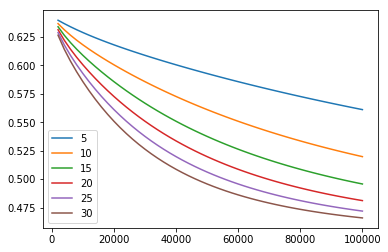

In [10]:
num_iterations = 100000
costss = []

for i in [5, 10, 15, 20, 25, 30]:
    w, b = initialize_with_zeros(X_train.shape[0])
    params, costs = optimize(w, b, X_train, Y_train, num_iterations, i, np.exp(-18))
    w = params["w"]
    b = params["b"]
    print('learning rate为' + str(i) + '时准确率：' + str(predict(w, b, X_test, Y_test)) + '%')
    costss.append(costs)

x_label = [i*2000 for i in range(1, 51)]
for i in range(len(costss)):
    plt.plot(x_label, costss[i], label=str((i+1)*5))
plt.legend()
plt.show()

以上使用TITANIC数据集，以下将使用自己生成的数据集进行验证

### 创建数据集

指定两个点，在周围分别使用高斯分布产生100个点

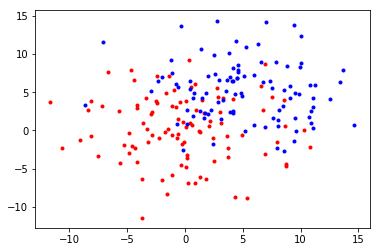

In [16]:
X0 = 0.0
Y0 = 0.0
X1 = 5.0
Y1 = 5.0

XG_Raw = np.zeros((2, 200))
YG_Raw = np.zeros((1, 200))

for i in range(100):
    XG_Raw[0, i] = X0 + random.gauss(0, 4)
    XG_Raw[1, i] = Y0 + random.gauss(0, 4)
    YG_Raw[0, i] = 0
for i in range(100, 200):
    XG_Raw[0, i] = X1 + random.gauss(0, 4)
    XG_Raw[1, i] = Y1 + random.gauss(0, 4)
    YG_Raw[0, i] = 1

plt.scatter(XG_Raw[0,0:100], XG_Raw[1,0:100], c='r', marker='.')
plt.scatter(XG_Raw[0,100:200], XG_Raw[1,100:200], c='b', marker='.')
plt.show()

### 产生训练集和测试集

In [17]:
XG_Train = np.r_[XG_Raw[0:2,0:70], XG_Raw[0:2,100:170]]
YG_Train = np.r_[YG_Raw[0:1,0:70], YG_Raw[0:1,100:170]]
XG_Test = np.r_[XG_Raw[0:2,70:100], XG_Raw[0:2,170:200]]
YG_Test = np.r_[YG_Raw[0:1,70:100], YG_Raw[0:1,170:200]]

### 带入算法

训练集准确率：95.71428571428571%
测试集准确率：100.0%


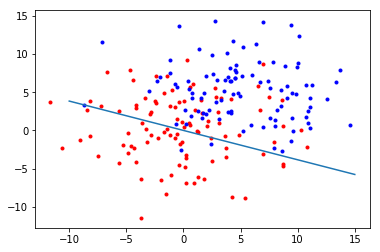

In [21]:
w, b = initialize_with_zeros(XG_Train.shape[0])
params, costs = optimize(w, b, XG_Train, YG_Train, 100000, 0.5, np.exp(-18))
w = params["w"]
b = params["b"]

print('训练集准确率：' + str(predict(w, b, XG_Train, YG_Train)) + '%')
print('测试集准确率：' + str(predict(w, b, XG_Test, YG_Test)) + '%')

plt.scatter(XG_Raw[0,0:100], XG_Raw[1,0:100], c='r', marker='.')
plt.scatter(XG_Raw[0,100:200], XG_Raw[1,100:200], c='b', marker='.')
plt.plot([-10, 15], [10*w[0,0]/w[1,0], -15*w[0,0]/w[1,0]])
plt.show()

### 测试非朴素贝叶斯数据集

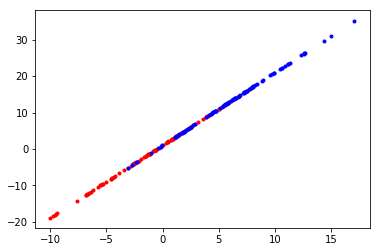

训练集准确率：94.28571428571429%
测试集准确率：96.66666666666667%


In [14]:
X0 = 0.0
Y0 = 0.0
X1 = 5.0
Y1 = 5.0

XG_Raw = np.zeros((2, 200))
YG_Raw = np.zeros((1, 200))

for i in range(100):
    XG_Raw[0, i] = X0 + random.gauss(0, 4)
    XG_Raw[1, i] = 2 * XG_Raw[0, i] + 1
    YG_Raw[0, i] = 0
for i in range(100, 200):
    XG_Raw[0, i] = X1 + random.gauss(0, 4)
    XG_Raw[1, i] = 2 * XG_Raw[0, i] + 1
    YG_Raw[0, i] = 1

plt.scatter(XG_Raw[0,0:100], XG_Raw[1,0:100], c='r', marker='.')
plt.scatter(XG_Raw[0,100:200], XG_Raw[1,100:200], c='b', marker='.')
plt.show()

XG_Train = np.r_[XG_Raw[0:2,0:70], XG_Raw[0:2,100:170]]
YG_Train = np.r_[YG_Raw[0:1,0:70], YG_Raw[0:1,100:170]]
XG_Test = np.r_[XG_Raw[0:2,70:100], XG_Raw[0:2,170:200]]
YG_Test = np.r_[YG_Raw[0:1,70:100], YG_Raw[0:1,170:200]]

w, b = initialize_with_zeros(XG_Train.shape[0])
params, costs = optimize(w, b, XG_Train, YG_Train, 100000, 0.5, np.exp(-18))
w = params["w"]
b = params["b"]

print('训练集准确率：' + str(predict(w, b, XG_Train, YG_Train)) + '%')
print('测试集准确率：' + str(predict(w, b, XG_Test, YG_Test)) + '%')